# Appendix B

This jupyter notebook contains analysis of counts of ED Breaches and Delayed Transfers Of Care at English Trusts August 2010-March 2017. 

# import dependancies

In [39]:
import numpy as np
import pandas as pd
#from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

# Load data

In [40]:
df = pd.read_csv('NHSE_data.csv')
df.shape

(80, 10)

In [41]:
df.head()

,year,month,total_attendances,total_attendances_t1,total_breaches,95%_targ,total_admissions,dtoc_a,dtoc_na,total_dtocs
0,2010-11,August,1719197.000,1138652.000,33184.00000,0.980698,425702.0000,2559,2381,4940
1,2010-11,September,1715117.000,1150728.000,41151.00000,0.976007,424900.0000,2647,2357,5004
2,2010-11,October,1753934.000,1163143.000,47414.00000,0.972967,436215.0000,2513,2075,4588
3,2010-11,November,1604591.000,1111294.571,46436.42857,0.971060,429099.0000,2352,2057,4409
4,2010-11,December,1647823.857,1159203.857,89917.28571,0.945433,452728.7143,1995,1866,3861


make flag for data used in previous analysis

In [42]:
df['flag_previous'] = 0

df.loc[0:68,'flag_previous'] = 1

In [43]:
df = df[df.flag_previous == 1] # remove most recent data to reproduce previosu analysis

In [44]:
df = df[['total_breaches','total_dtocs']]

# Data briefing reproduction

A reproduction of the analysis in BMJ data briefing.

In [45]:
from scipy import stats

In [46]:
# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(df['total_dtocs'],df['total_breaches'])

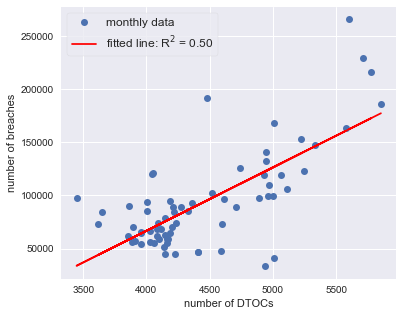

In [47]:
fig, ax = plt.subplots(figsize=(6,5))
y = df['total_breaches']
x = df['total_dtocs']
plt.plot(x,y,'o', label='monthly data')
plt.plot(df['total_dtocs'], intercept + slope*x, 'r', label='fitted line: R$^2$ = {0:.2f}'.format(r_value**2))
plt.legend(frameon=True,fontsize='large')
ax.set_xlabel('number of DTOCs')
ax.set_ylabel('number of breaches')
#plt.
plt.show()

In [48]:
fig.savefig('original.png',dpi=600)

In [49]:
r_value**2

0.50418561896447456

#### distribution of data

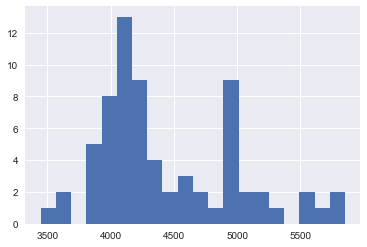

In [50]:
df.total_dtocs.hist(bins=20);

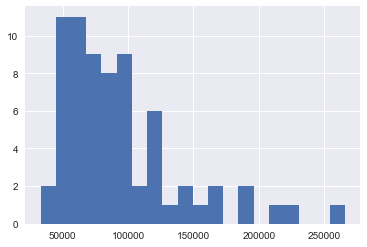

In [51]:
df.total_breaches.hist(bins=20);

#### correaltion coefficient

Data appears to not be noramlly distributed. Hence, we use spearman rank correlation coefficient.

In [52]:
df[['total_dtocs','total_breaches']].corr('spearman')

,total_dtocs,total_breaches
total_dtocs,1.000000,0.541635
total_breaches,0.541635,1.000000


In [53]:
from scipy.stats.stats import pearsonr

In [54]:
pearsonr(df['total_dtocs'],df['total_breaches'])

(0.71006029248541602, 8.3789201850835955e-12)

In [55]:
from scipy.stats.stats import spearmanr

In [56]:
spearmanr(df['total_dtocs'],df['total_breaches'])

SpearmanrResult(correlation=0.54163469655066099, pvalue=1.5399135359740895e-06)

# investigate autocorrelation

In [57]:
def auto_corr(df,column,lags,how='spearman'):
    
    #### get lagged cols
    dftemp = pd.DataFrame(df[column])
    result = dftemp.copy()
    #result = pd.DataFrame()
    
    #### create new columns with shifted vars
    for i in np.arange(1,lags):

        dftemp2 = dftemp.shift(i).copy() # get new series with shoifted data
        dftemp2.rename(columns={column:str(i)},inplace=True) #rename col to lag no
        result  = result.merge(dftemp2, how='outer',left_index=True,right_index=True) # merge with running results df
        
    # calc correlation coef nad get table of results
    result_corr = result.corr(how)[column].reset_index(drop=True)
    return(result_corr)

In [58]:
def compute_crosscorr_mult_inputs(df,xvars,lags,title='', how='spearman'):
    ''' create df with lagged correlation scores (auto-correlation) for multiple variables'''
    
    corr_scores = pd.DataFrame()
    for i in xvars:
        corrs = auto_corr(df,i,lags,how)
        corr_scores[i] = corrs
    ax = plt.subplot()
    corr_scores.plot(ax=ax)
    ax.set_ylabel('correlation coef')
    ax.set_xlabel('lag (months)')
    ax.set_ylim([-0.4,1])
    ax.plot((0,corr_scores.shape[0]),(0,0),'k--') # plot 0 line
    ax.set_title(title)
    return(corr_scores)

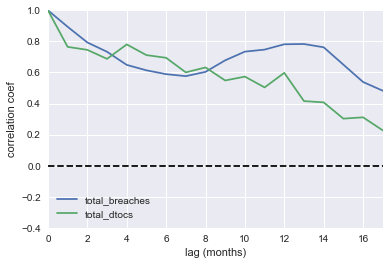

In [59]:
corr_scores = compute_crosscorr_mult_inputs(df,['total_breaches','total_dtocs'],18,how='spearman')

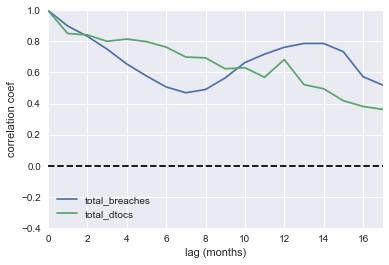

In [60]:
corr_scores = compute_crosscorr_mult_inputs(df,['total_breaches','total_dtocs'],18,how='pearson')

#### using dickey-fuller test to ascertain if data is stationarity:

In [61]:
from statsmodels.tsa.stattools import adfuller

In [62]:
def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [63]:
check_stationarity(df['total_breaches'])

ADF Statistic: -1.555714
p-value: 0.505793
	1%: -3.530
	5%: -2.905
	10%: -2.590


In [64]:
check_stationarity(df['total_dtocs'])

ADF Statistic: 1.641969
p-value: 0.997978
	1%: -3.551
	5%: -2.914
	10%: -2.595


There is high auto-correlation in both the numbers of breaches & numbers of dtocs. This is due to each timeseries having  increasing growth over time, i.e. they are non-stationary. This is very clear upon plotting the time-series below.

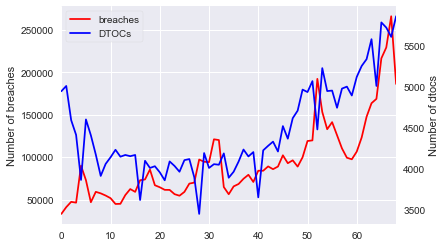

In [65]:
fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

df.total_breaches.plot(color='red', ax=ax)#, width=width)#, position=1)
df.total_dtocs.plot(color='blue', ax=ax2)

ax.set_ylabel('Number of breaches')
ax2.set_ylabel('Number of dtocs')
ax2.grid(b=False)

#sort legend
lns = ax.get_lines()+ax2.get_lines()
ax.legend(lns,['breaches','DTOCs'],frameon=True)

plt.show()

### detrend using fitted polynomial

We can detrend the time-series by fitting polynomial equations and subtracting these from the time-series.

In [66]:
import scipy

#### fit DTOCs with polynomial

In [67]:
def func_dtoc(x, a, b, c):
    return (a * x) + (b * x**2) + c

In [68]:
def detrend_using_func(dta,column,func,ylabel,color='b'):
    
    #### fit func
    xdata = dta.index
    ydata = dta[column]
    popt, pcov = scipy.optimize.curve_fit(func, xdata, ydata)
    
    #### plot fig
    fig = plt.figure() # Create matplotlib figure

    ax = fig.add_subplot(111) # Create matplotlib axes
    df[column].plot(color=color, ax=ax, label=ylabel)#, width=width)#, position=0)
    plt.plot(xdata, func(xdata, *popt), color+ '--',
              label='fit:a=%5.3f,  b=%5.3f, c=%5.3f' % tuple(popt)) #

    ax.set_ylabel(ylabel)
    ax.legend(frameon=True)
    plt.show()
    
    #### make new column with detrended data
    dta.loc[dta.index,column+'_detrend'] = dta[column] - func(dta[column].index,popt[0],popt[1],popt[2])
    
    return dta

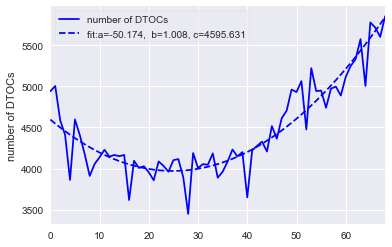

In [69]:
df = detrend_using_func(df,'total_dtocs',func_dtoc,'number of DTOCs')

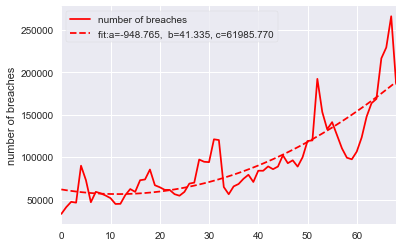

In [70]:
df = detrend_using_func(df,'total_breaches',func_dtoc,'number of breaches','r')

Plotting the detrended time-series (below) we see there is now no increasing trend over time.

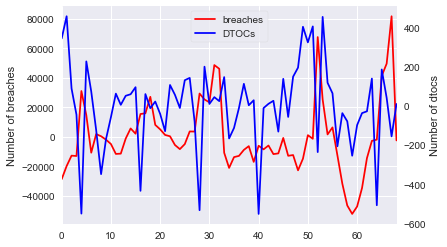

In [71]:
fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

df.total_breaches_detrend.plot(color='red', ax=ax)#, width=width)#, position=1)
df.total_dtocs_detrend.plot(color='blue', ax=ax2)

ax.set_ylabel('Number of breaches')
ax2.set_ylabel('Number of dtocs')
ax2.grid(b=False)

#sort legend
lns = ax.get_lines()+ax2.get_lines()
ax2.legend(lns,['breaches','DTOCs'],frameon=True)

plt.show()

Although we have removed the trend, it appears that the DTOCs time-series may still not be stationary upon performing a dickey-fuller test.  

In [72]:
check_stationarity(df['total_breaches_detrend'])

ADF Statistic: -3.952409
p-value: 0.001681
	1%: -3.530
	5%: -2.905
	10%: -2.590


In [73]:
check_stationarity(df['total_dtocs_detrend'])

ADF Statistic: -1.586171
p-value: 0.490537
	1%: -3.551
	5%: -2.914
	10%: -2.595


# Analysis on detrended data

Completing the same analyses on the detrended data as before we find there are much smaller correlation coefcients.

In [74]:
# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(df['total_dtocs_detrend'],df['total_breaches_detrend'])

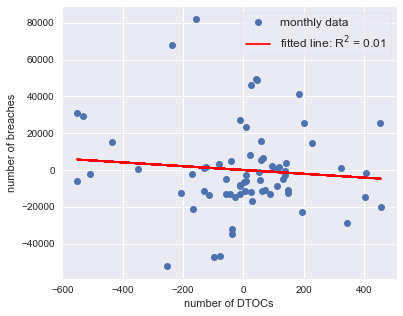

In [75]:
fig, ax = plt.subplots(figsize=(6,5))
y = df['total_breaches_detrend']
x = df['total_dtocs_detrend']
plt.plot(x,y,'o', label='monthly data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line: R$^2$ = {0:.2f}'.format(r_value**2))
plt.legend(frameon=True,fontsize='large')
ax.set_xlabel('number of DTOCs')
ax.set_ylabel('number of breaches')
#plt.
plt.show()

In [76]:
fig.savefig('detrended.png',dpi=600)

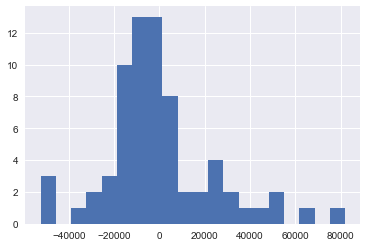

In [77]:
df.total_breaches_detrend.hist(bins=20)

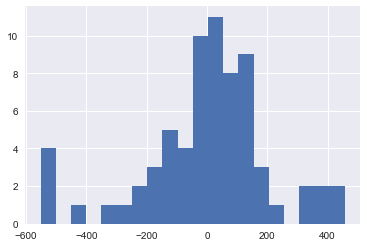

In [78]:
df.total_dtocs_detrend.hist(bins=20)

In [79]:
xdata=df['total_breaches']
ydata=df['total_dtocs']

from scipy.stats.stats import spearmanr
from scipy.stats.stats import pearsonr

def test_corrs(xdata,ydata,test):
    result = test(xdata,ydata)
    return(result)

def create_test_df(df):
    index =[]
    corrs = []
    ps = []
    
    corr,p = test_corrs(df['total_breaches'],df['total_dtocs'],pearsonr)
    index.append('original (pearson)')
    corrs.append(corr)
    ps.append(p)
    
    
    corr,p = test_corrs(df['total_breaches'],df['total_dtocs'],spearmanr)
    index.append('original (spearman)')
    corrs.append(corr)
    ps.append(p)
    
    corr,p = test_corrs(df['total_breaches_detrend'],df['total_dtocs_detrend'],pearsonr)
    index.append('detrended (pearson)')
    corrs.append(corr)
    ps.append(p)
    
    
    
    corr,p = test_corrs(df['total_breaches_detrend'],df['total_dtocs_detrend'],spearmanr)
    index.append('detrended (spearman)')
    corrs.append(corr)
    ps.append(p)
    
    
    result = pd.DataFrame(data={'correlations':corrs,'p_values':ps},index=index)
    return(result)
    
corrs = create_test_df(df)

In [80]:
corrs.round(4)

,correlations,p_values
original (pearson),0.7101,0.0000
original (spearman),0.5416,0.0000
detrended (pearson),-0.0915,0.4544
detrended (spearman),0.0178,0.8844


The p-value roughly indicates the probability of an uncorrelated system
 producing datasets that have a Pearson correlation at least as extreme
 as the one computed from these datasets. The p-values are not entirely
 reliable but are probably reasonable for datasets larger than 500 or so.

# investigate autocorrelation in time series

The detrended time-series have different levels of autocorrelation. The number of breaches has a reasonably strong correlation values with 12 months lag. This is an expected seasonal variation. The DTOCs timeseries may show a similar pattern, but it is not as clear.  

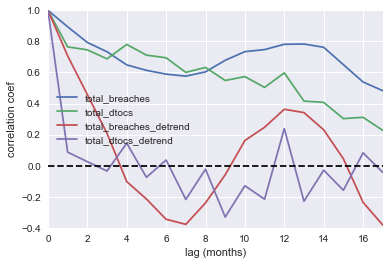

In [54]:
corr_scores_diff = compute_crosscorr_mult_inputs(df,['total_breaches','total_dtocs','total_breaches_detrend','total_dtocs_detrend'],18)

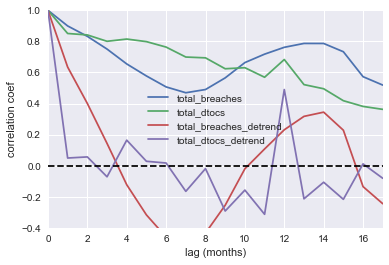

In [55]:
corr_scores_diff = compute_crosscorr_mult_inputs(df,['total_breaches','total_dtocs','total_breaches_detrend','total_dtocs_detrend'],18, how='pearson')

!# check that these are same results as ACF in statsmodles?

# Dev

In [56]:
break

SyntaxError: 'break' outside loop (<ipython-input-56-6aaf1f276005>, line 1)

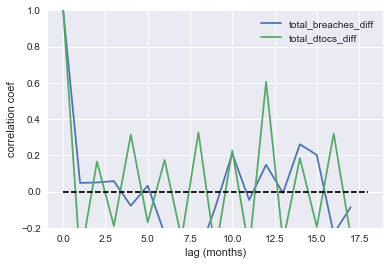

In [129]:
corr_scores_diff = compute_crosscorr_mult_inputs(df,['total_breaches_diff','total_dtocs_diff'],18)

# Testing other acf methods

In [73]:
from statsmodels.tsa.stattools import acf, pacf

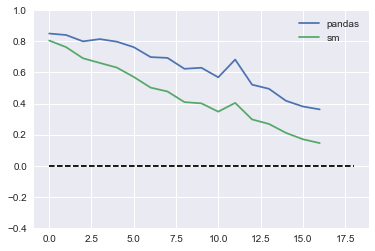

In [106]:
data = df['total_dtocs']
lags = 18

acf2 = acf(data)[1:lags]

acf1 = [data.autocorr(i) for i in range(1,lags)]

#fig = plt.figure()
ax = plt.subplot()
pd.DataFrame({'pandas':acf1,'sm':acf2}).plot(ax=ax)
ax.set_ylim(-0.4,1)

ax.plot((0,corr_scores.shape[0]),(0,0),'k--') # plot 0 line
    

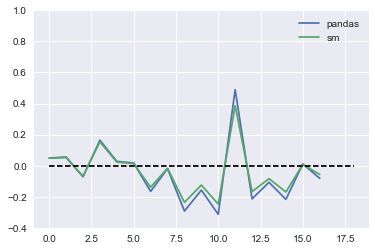

In [109]:
data = df['total_dtocs_detrend']
lags = 18

acf2 = acf(data)[1:lags]

acf1 = [data.autocorr(i) for i in range(1,lags)]

#fig = plt.figure()
ax = plt.subplot()
pd.DataFrame({'pandas':acf1,'sm':acf2}).plot(ax=ax)
ax.set_ylim(-0.4,1)

ax.plot((0,corr_scores.shape[0]),(0,0),'k--') # plot 0 line
    

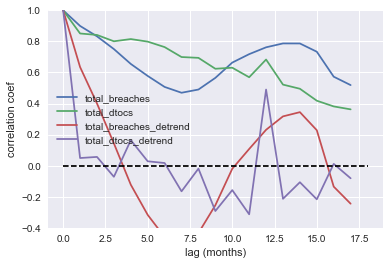

In [35]:
corr_scores_diff = compute_crosscorr_mult_inputs(df,['total_breaches','total_dtocs','total_breaches_detrend','total_dtocs_detrend'],18, how='pearson')

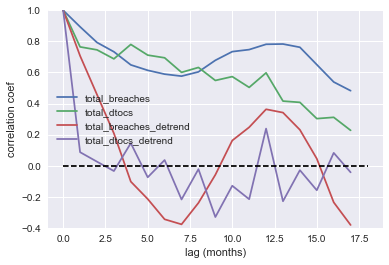

In [99]:
corr_scores_diff = compute_crosscorr_mult_inputs(df,['total_breaches','total_dtocs','total_breaches_detrend','total_dtocs_detrend'],18)

(19,)
[1.0, 0.89941675731938286, 0.83244178544114444, 0.75042724366158819, 0.65474652688351853, 0.57735820270494809, 0.5067536166059623, 0.46920945417446652, 0.48998665433901217, 0.56501455868164041, 0.66346906089269442, 0.71773681626351549, 0.76181877592184644, 0.78675959050041566, 0.78651587855840221, 0.73331559484274922, 0.57261956076297504, 0.51856740853499728, 0.46652183281248844]


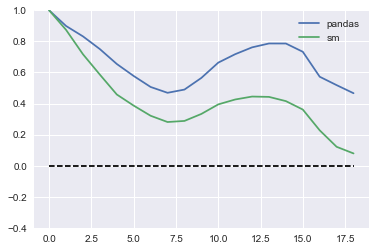

In [136]:
data = df['total_breaches']
lags = 18

acf2 = acf(data,nlags = lags,unbiased=True)
print(acf2.shape)

acf1 = [data.autocorr(i) for i in range(0,lags+1)]
print(acf1)

#fig = plt.figure()
ax = plt.subplot()
pd.DataFrame({'pandas':acf1,'sm':acf2}).plot(ax=ax)
ax.set_ylim(-0.4,1)

ax.plot((0,corr_scores.shape[0]),(0,0),'k--') # plot 0 line
    

(19,)
[1.0, 0.63463877164541316, 0.40014119266838138, 0.14306684162763467, -0.12298394967235839, -0.31724655299368809, -0.45988442385260325, -0.50328013901373347, -0.43399717274555921, -0.25503748455390324, -0.020199057841945527, 0.10716659570006588, 0.2306977076244342, 0.31709066339119929, 0.34429961579004242, 0.22798094000747998, -0.13520659842676411, -0.24515424380639034, -0.30235035378970554]


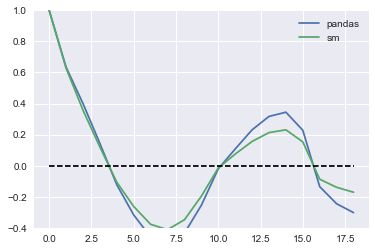

In [133]:
data = df['total_breaches_detrend']
lags = 18

acf2 = acf(data,nlags = lags)
print(acf2.shape)

acf1 = [data.autocorr(i) for i in range(0,lags+1)]
print(acf1)

#fig = plt.figure()
ax = plt.subplot()
pd.DataFrame({'pandas':acf1,'sm':acf2}).plot(ax=ax)
ax.set_ylim(-0.4,1)

ax.plot((0,corr_scores.shape[0]),(0,0),'k--') # plot 0 line
    